Preparing Data And Preprocessing

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chloy/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


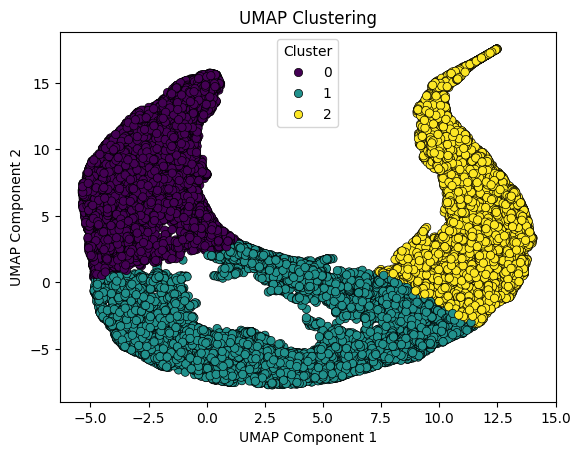

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import LocalOutlierFactor
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import umap.umap_ as umap

# ---- STEP 1: LOAD DATA ----
df = pd.read_excel('./data_files/Data_re.xlsx')  # Ensure the file exists

# ---- STEP 2: FEATURE SELECTION ----
cols_to_keep = ['g_flux', 'r_flux', 'i_flux', 'y_flux', 'z_flux', 'specz_redshift']
df_selected = df[cols_to_keep].copy()

# Compute Flux Color Indices
df_selected['g_r'] = df_selected['g_flux'] - df_selected['r_flux']
df_selected['r_i'] = df_selected['r_flux'] - df_selected['i_flux']
df_selected['i_y'] = df_selected['i_flux'] - df_selected['y_flux']
df_selected['y_z'] = df_selected['y_flux'] - df_selected['z_flux']

# ---- STEP 3: REMOVE OUTLIERS ----
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
outlier_scores = lof.fit_predict(df_selected.drop(columns=['specz_redshift']))
df_clean = df_selected[outlier_scores == 1].copy()

# ---- STEP 4: SCALING & TRANSFORMING ----
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean.drop(columns=['specz_redshift']))

# Apply Power Transformation (Yeo-Johnson for normalizing skewed data)
power_transformer = PowerTransformer(method='yeo-johnson')
df_transformed = power_transformer.fit_transform(df_scaled)

# ---- STEP 5: DIMENSIONALITY REDUCTION WITH UMAP ----
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(df_transformed)

# ---- STEP 6: OPTIONAL PCA FOR EXPLORATION ----
pca = PCA(n_components=3)
X_pca = pca.fit_transform(df_transformed)

# ---- STEP 7: CLUSTERING ----
kmeans = KMeans(n_clusters=3, random_state=42)
df_clean['Cluster'] = kmeans.fit_predict(X_umap)

# ---- PLOT RESULTS ----
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=df_clean['Cluster'], palette='viridis', edgecolor='k')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Clustering')
plt.legend(title="Cluster")  # Optional: Adds a title to the legend
plt.show()



checking 

In [2]:
print(df.head())
print(df.info())
print(df.describe())

                                               coord       dec  \
0   b'(179325.3125, 99694.8046875, -21178.96484375)' -5.893433   
1  b'(179236.609375, 99349.8203125, -23431.181640... -6.522742   
2     b'(179281.5, 99283.5078125, -23368.759765625)' -6.505290   
3  b'(179365.171875, 99158.046875, -23259.0839843... -6.474628   
4      b'(179366.421875, 99172.25, -23188.84765625)' -6.454993   

   g_central_image_pop_10px_rad  g_central_image_pop_15px_rad  \
0                             1                             1   
1                             1                             1   
2                             1                             1   
3                             1                             1   
4                             1                             1   

   g_central_image_pop_5px_rad  g_cmodel_mag  g_cmodel_magsigma  \
0                            1     20.314907           0.002624   
1                            1     22.217360           0.010902   
2          

Clustering (DBScan, K means and Gaussian Mixture Method)

Optimal eps for DBSCAN: 0.323
Optimal k for K-Means/GMM: 9
Silhouette Scores - KMeans: 0.441, GMM: 0.395, DBSCAN: None


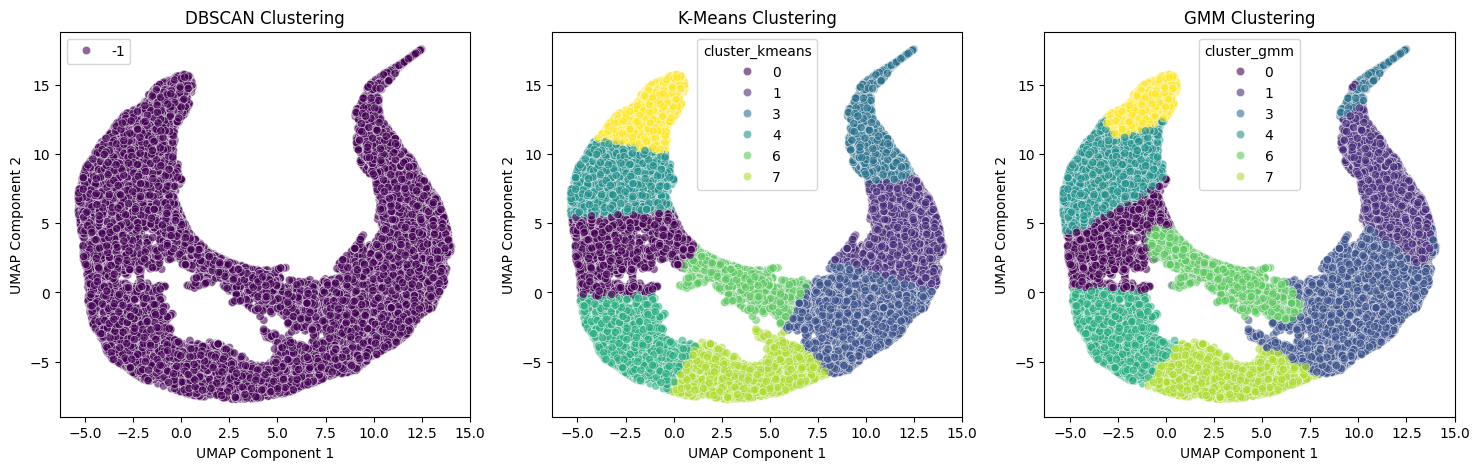

In [3]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from kneed import KneeLocator

# ---- STEP 6: DETERMINE OPTIMAL DBSCAN EPS ----
k = 5  # Typically, min_samples value
nearest_neighbors = NearestNeighbors(n_neighbors=k)
nearest_neighbors.fit(X_umap)
distances, indices = nearest_neighbors.kneighbors(X_umap)

# Sort distances to find the "knee" point
distances = np.sort(distances[:, -1])

# Use KneeLocator to find optimal epsilon
knee_locator = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
optimal_eps = distances[knee_locator.elbow] if knee_locator.elbow is not None else np.percentile(distances, 95)

print(f"Optimal eps for DBSCAN: {optimal_eps:.3f}")

# ---- STEP 6A: APPLY DBSCAN CLUSTERING ----
min_samples = max(5, int(0.05 * len(X_umap)))  # At least 5, or 5% of dataset
dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples, metric='euclidean')
cluster_labels_dbscan = dbscan.fit_predict(X_umap)
df_clean.loc[:, 'cluster_dbscan'] = cluster_labels_dbscan

# ---- STEP 6B: APPLY K-MEANS & GMM ----
inertia = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_umap)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_umap, labels))

knee_locator_sil = KneeLocator(k_range, silhouette_scores, curve="convex", direction="increasing")
optimal_k = knee_locator_sil.elbow if knee_locator_sil.elbow is not None else 3

print(f"Optimal k for K-Means/GMM: {optimal_k}")

# Apply K-Means with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
df_clean.loc[:, 'cluster_kmeans'] = kmeans.fit_predict(X_umap)

# Apply Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
df_clean.loc[:, 'cluster_gmm'] = gmm.fit_predict(X_umap)

# ---- STEP 7: COMPUTE SILHOUETTE SCORES ----
silhouette_kmeans = silhouette_score(X_umap, df_clean['cluster_kmeans'])
silhouette_gmm = silhouette_score(X_umap, df_clean['cluster_gmm'])

if len(set(cluster_labels_dbscan)) > 1:  # Ensure valid clusters exist
    silhouette_dbscan = silhouette_score(
        X_umap[df_clean['cluster_dbscan'] != -1], 
        df_clean['cluster_dbscan'][df_clean['cluster_dbscan'] != -1]
    )
else:
    silhouette_dbscan = None  # Not enough clusters for silhouette score

print(f"Silhouette Scores - KMeans: {silhouette_kmeans:.3f}, GMM: {silhouette_gmm:.3f}, DBSCAN: {silhouette_dbscan}")

# ---- STEP 8: VISUALIZE CLUSTERING METHODS (2D PLOTS) ----
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# DBSCAN 2D Plot
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=cluster_labels_dbscan, palette='viridis', alpha=0.6, ax=ax[0])
ax[0].set_title("DBSCAN Clustering")
ax[0].set_xlabel("UMAP Component 1")
ax[0].set_ylabel("UMAP Component 2")

sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=df_clean['cluster_kmeans'], palette='viridis', alpha=0.6, ax=ax[1])
ax[1].set_title("K-Means Clustering")
ax[1].set_xlabel("UMAP Component 1")
ax[1].set_ylabel("UMAP Component 2")

sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=df_clean['cluster_gmm'], palette='viridis', alpha=0.6, ax=ax[2])
ax[2].set_title("GMM Clustering")
ax[2].set_xlabel("UMAP Component 1")
ax[2].set_ylabel("UMAP Component 2")

plt.show()


Random Forest

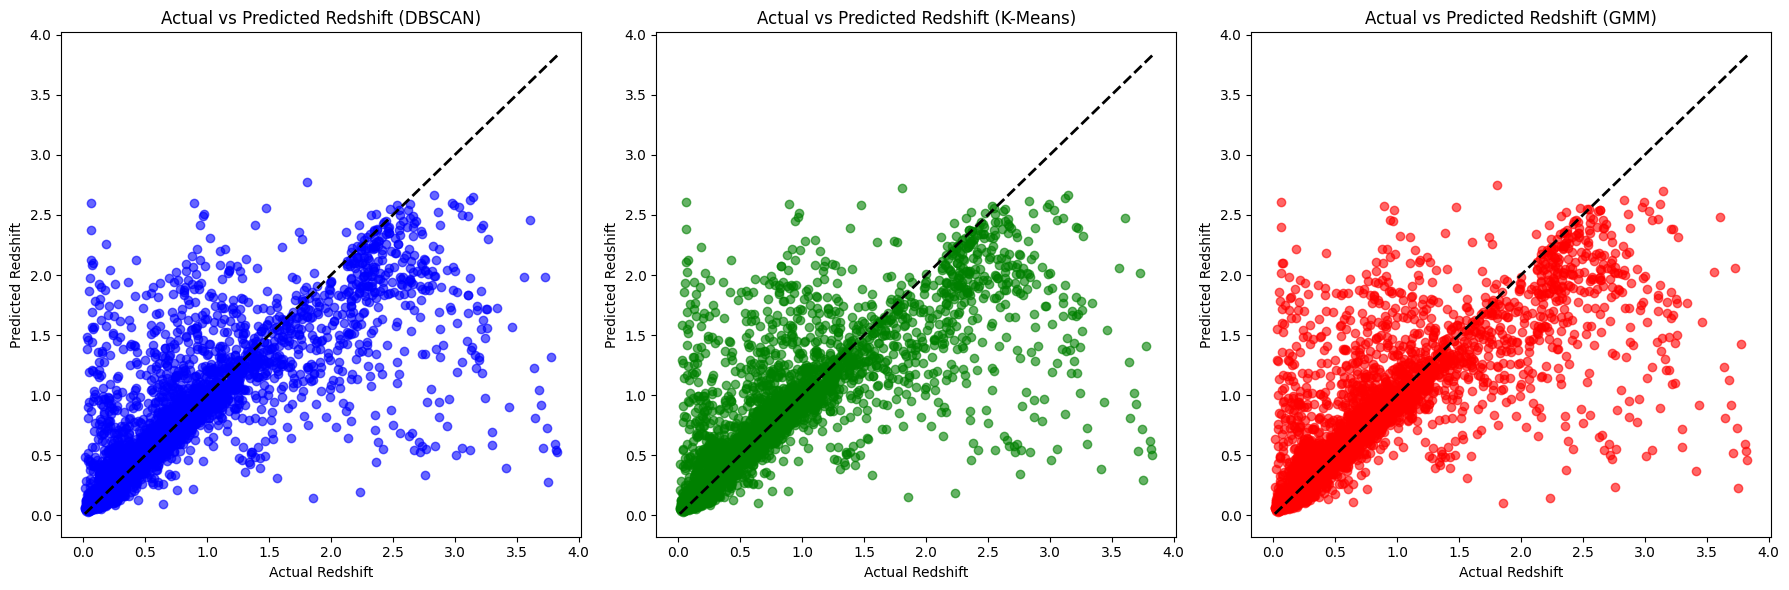

Random Forest Regression Results:
CLUSTER_DBSCAN - MSE: 0.103494, R2: 0.673538
CLUSTER_KMEANS - MSE: 0.103177, R2: 0.674537
CLUSTER_GMM - MSE: 0.103596, R2: 0.673214


In [4]:
# ---- STEP 8: RANDOM FOREST REGRESSION ----
# Train separate Random Forest models for each clustering method using flux features

results = {}

for cluster_type in ['cluster_dbscan', 'cluster_kmeans', 'cluster_gmm']:
    df_temp = pd.get_dummies(df_clean, columns=[cluster_type], prefix=[f'clust_{cluster_type}'])
    X = df_temp[['g_flux', 'r_flux', 'i_flux', 'y_flux', 'z_flux'] + 
                [col for col in df_temp.columns if col.startswith(f'clust_{cluster_type}')]]
    y = df_temp['specz_redshift']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[cluster_type] = {'MSE': mse, 'R2': r2, 'y_pred': y_pred}

# ---- STEP 9: VISUALIZE REGRESSION RESULTS ----
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
titles = ['DBSCAN', 'K-Means', 'GMM']
colors = ['blue', 'green', 'red']

for i, cluster_type in enumerate(results.keys()):
    ax[i].scatter(y_test, results[cluster_type]['y_pred'], alpha=0.6, color=colors[i])
    ax[i].set_xlabel('Actual Redshift')
    ax[i].set_ylabel('Predicted Redshift')
    ax[i].set_title(f'Actual vs Predicted Redshift ({titles[i]})')
    ax[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.tight_layout()
plt.show()

# ---- STEP 10: COMPARE RESULTS ACROSS CLUSTERING METHODS ----
print("Random Forest Regression Results:")
for cluster_type, metrics in results.items():
    print(f"{cluster_type.upper()} - MSE: {metrics['MSE']:.6f}, R2: {metrics['R2']:.6f}")


Checking 

In [5]:
print(df_clean.head())
print(df_clean.columns)

         g_flux        r_flux        i_flux        y_flux        z_flux  \
0  7.482335e-09  2.987891e-08  5.117533e-08  8.117985e-08  6.737572e-08   
1  1.297347e-09  5.643225e-09  1.319162e-08  2.141019e-08  1.828079e-08   
2  3.471398e-09  1.571304e-08  3.743521e-08  6.504857e-08  5.585498e-08   
3  4.114510e-08  1.090914e-07  1.841788e-07  3.080686e-07  2.402212e-07   
4  3.987357e-09  1.373544e-08  2.634882e-08  4.449762e-08  3.527128e-08   

   specz_redshift           g_r           r_i           i_y           y_z  \
0         0.31652 -2.239657e-08 -2.129643e-08 -3.000452e-08  1.380413e-08   
1         0.56769 -4.345878e-09 -7.548391e-09 -8.218576e-09  3.129404e-09   
2         0.53428 -1.224164e-08 -2.172218e-08 -2.761336e-08  9.193588e-09   
3         0.11878 -6.794635e-08 -7.508739e-08 -1.238898e-07  6.784739e-08   
4         0.23497 -9.748082e-09 -1.261338e-08 -1.814880e-08  9.226337e-09   

   Cluster  cluster_dbscan  cluster_kmeans  cluster_gmm  
0        2               0  

SVR and UMAP


/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chloy/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


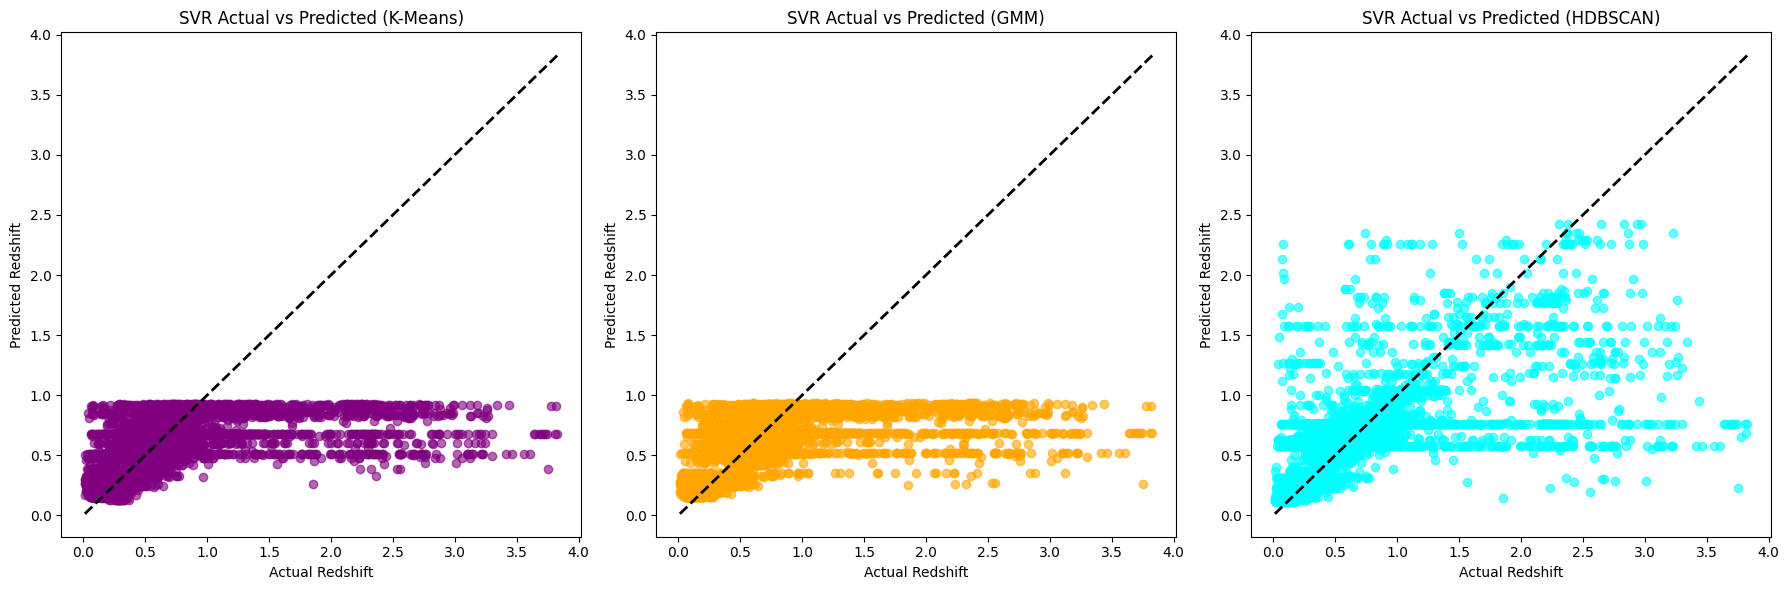

SVR Regression Results:
CLUSTER_KMEANS - MSE: 0.227899, R2: 0.281111
CLUSTER_GMM - MSE: 0.226127, R2: 0.286701
CLUSTER_HDBSCAN - MSE: 0.167378, R2: 0.472019


In [6]:
# Add-Ons for Photometric Redshift Estimation 
# Fixing UMAP Import Issue and Enhancing Preprocessing

# ---- STEP 11: Install and Import UMAP Properly ----
# Ensure proper UMAP installation: pip install umap-learn
from umap import UMAP  

umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap.fit_transform(df_transformed)

# ---- STEP 12: Add More Color Indices (Using Flux Values) ----
df_clean['u_g'] = df_clean['g_flux'] - df_clean['r_flux']
df_clean['g_r'] = df_clean['r_flux'] - df_clean['i_flux']
df_clean['r_i'] = df_clean['i_flux'] - df_clean['y_flux']
df_clean['i_z'] = df_clean['y_flux'] - df_clean['z_flux']

# ---- STEP 13: Additional Clustering (HDBSCAN) for SVR Comparison ----
try:
    from hdbscan import HDBSCAN
except ImportError:
    print("HDBSCAN not installed. Use: pip install hdbscan")
    raise

hdbscan = HDBSCAN(min_cluster_size=8)
df_clean['cluster_hdbscan'] = hdbscan.fit_predict(X_umap)

# ---- STEP 14: SVR Regression for Redshift Estimation ----
from sklearn.svm import SVR
svr_results = {}

for cluster_type in ['cluster_kmeans', 'cluster_gmm', 'cluster_hdbscan']:
    df_temp = pd.get_dummies(df_clean, columns=[cluster_type], prefix=[f'clust_{cluster_type}'])
    X = df_temp.drop(columns=['specz_redshift'])
    y = df_temp['specz_redshift']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    svr_results[cluster_type] = {'MSE': mse, 'R2': r2, 'y_pred': y_pred}

# ---- STEP 15: Plot SVR Results ----
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
titles = ['K-Means', 'GMM', 'HDBSCAN']
colors = ['purple', 'orange', 'cyan']

for i, cluster_type in enumerate(svr_results.keys()):
    ax[i].scatter(y_test, svr_results[cluster_type]['y_pred'], alpha=0.6, color=colors[i])
    ax[i].set_title(f'SVR Actual vs Predicted ({titles[i]})')
    ax[i].set_xlabel('Actual Redshift')
    ax[i].set_ylabel('Predicted Redshift')
    ax[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.tight_layout()
plt.show()

# ---- Print SVR Performance Metrics ----
print('SVR Regression Results:')
for cluster_type, metrics in svr_results.items():
    print(f"{cluster_type.upper()} - MSE: {metrics['MSE']:.6f}, R2: {metrics['R2']:.6f}")


XGBoost , Gradient boosting and MLP NN

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
import faiss  # Faster nearest neighbor search

# ---- STEP 1: ADD MORE COLOR INDICES ----
# Verify flux columns exist before calculating new features
if all(col in df_clean.columns for col in ['g_flux', 'r_flux', 'i_flux', 'y_flux', 'z_flux']):
    df_clean['g_i'] = df_clean['g_flux'] - df_clean['i_flux']
    df_clean['r_z'] = df_clean['r_flux'] - df_clean['z_flux']
    df_clean['i_y_z'] = df_clean['i_flux'] - df_clean['y_flux'] - df_clean['z_flux']
else:
    raise ValueError("Missing required flux columns in df_clean.")

# ---- STEP 2: DEFINE FEATURES & TARGET ----
features = ['g_flux', 'r_flux', 'i_flux', 'y_flux', 'z_flux', 
            'g_r', 'r_i', 'i_y', 'y_z', 'g_i', 'r_z', 'i_y_z']

# Include cluster one-hot encoding for different clustering techniques
if 'cluster_kmeans' in df_clean.columns and 'cluster_gmm' in df_clean.columns and 'cluster_hdbscan' in df_clean.columns:
    df_encoded = pd.get_dummies(df_clean, columns=['cluster_kmeans', 'cluster_gmm', 'cluster_hdbscan'], 
                                prefix=['clust_kmeans', 'clust_gmm', 'clust_hdbscan'])
else:
    raise ValueError("Cluster columns are missing in df_clean.")

X = df_encoded[features + [col for col in df_encoded.columns if col.startswith('clust_')]]
y = df_encoded['specz_redshift']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---- STEP 3: APPLY XGBOOST ----
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - MSE: {mse_xgb:.6f}, R2: {r2_xgb:.6f}")

# ---- STEP 4: APPLY GRADIENT BOOSTING ----
gbr = GradientBoostingRegressor(n_estimators=150, learning_rate=0.05, random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print(f"Gradient Boosting - MSE: {mse_gbr:.6f}, R2: {r2_gbr:.6f}")

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ---- STEP 5: TRY MLP NEURAL NETWORK ----
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print(f"MLP Neural Net - MSE: {mse_mlp:.6f}, R2: {r2_mlp:.6f}")

# ---- STEP 6: OPTIONAL - FASTER NEAREST NEIGHBOR SEARCH FOR DBSCAN ----
index = faiss.IndexFlatL2(X_train.shape[1])  # L2 distance (Euclidean)
index.add(X_train.astype('float32'))  # FAISS requires float32
_, indices = index.search(X_train.astype('float32'), k=5)  # Find 5 nearest neighbors


XGBoost - MSE: 0.099036, R2: 0.687598
Gradient Boosting - MSE: 0.112597, R2: 0.644823
MLP Neural Net - MSE: 0.154431, R2: 0.512862


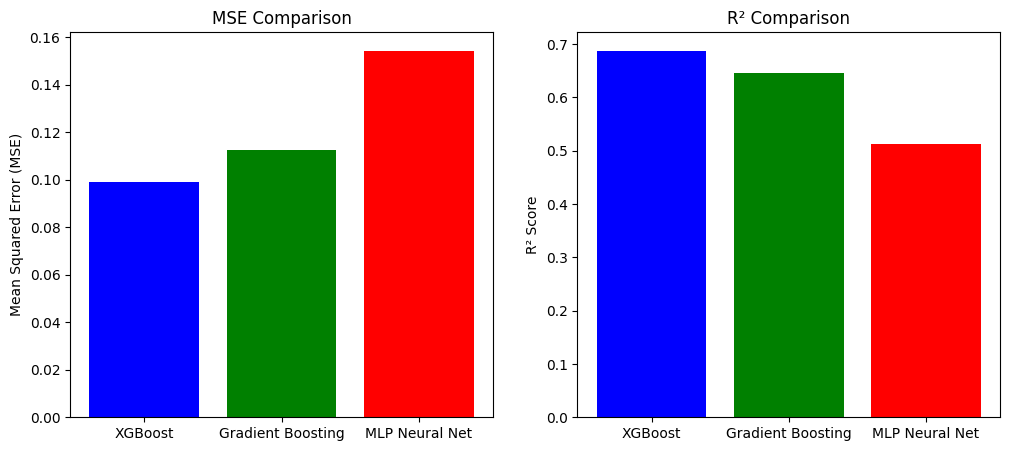

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use Seaborn's style for better aesthetics
sns.set_theme(style="whitegrid")

# Create a DataFrame for Seaborn
import pandas as pd
df_scores = pd.DataFrame({
    'Model': ['XGBoost', 'Gradient Boosting', 'MLP Neural Net'],
    'MSE': mse_scores,
    'R² Score': r2_scores
})

# Create figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# MSE Plot (with log scale)
sns.barplot(data=df_scores, x="Model", y="MSE", ax=ax[0], palette="coolwarm")
ax[0].set_yscale('log')  # Log scale for better visualization
ax[0].set_title("MSE Comparison")

# R² Score Plot
sns.barplot(data=df_scores, x="Model", y="R² Score", ax=ax[1], palette="coolwarm")
ax[1].axhline(y=0, color='black', linestyle='dashed', linewidth=1)  # Baseline at R² = 0
ax[1].set_title("R² Comparison")

plt.show()


Fine Tuning XGBoost Hyper-Parameters

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint  # For random distributions

# ---- Define Parameter Distributions ----
xgb_param_dist = {
    'n_estimators': randint(100, 500),  # Randomly choose between 100-500 trees
    'learning_rate': uniform(0.01, 0.2),  # Continuous range for better granularity
    'max_depth': randint(3, 10),  # Shallower trees might generalize better
    'subsample': uniform(0.7, 0.3),  # Random fraction of data for each tree
    'colsample_bytree': uniform(0.7, 0.3),  # Random fraction of features for each tree
}

xgb = XGBRegressor(random_state=42)
xgb_random = RandomizedSearchCV(
    xgb, xgb_param_dist, 
    n_iter=20,  # 20 random combinations (adjust based on computation time)
    cv=5,  # More folds for stability
    scoring='r2', 
    verbose=2, 
    n_jobs=-1, 
    random_state=42
)

# Fit the model
xgb_random.fit(X_train, y_train)

# Best model evaluation
best_xgb = xgb_random.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Tuned XGBoost - Best Params: {xgb_random.best_params_}")
print(f"Tuned XGBoost - MSE: {mse_xgb:.6f}, R2: {r2_xgb:.6f}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=  20.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=  21.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=  21.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=  21.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=  21.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=  22.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0; total time=  28.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=  28.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estima

Emsemble (XGBoost + RF + Gradient Boost)

Stacking Ensemble - MSE: 0.092646, R2: 0.707756


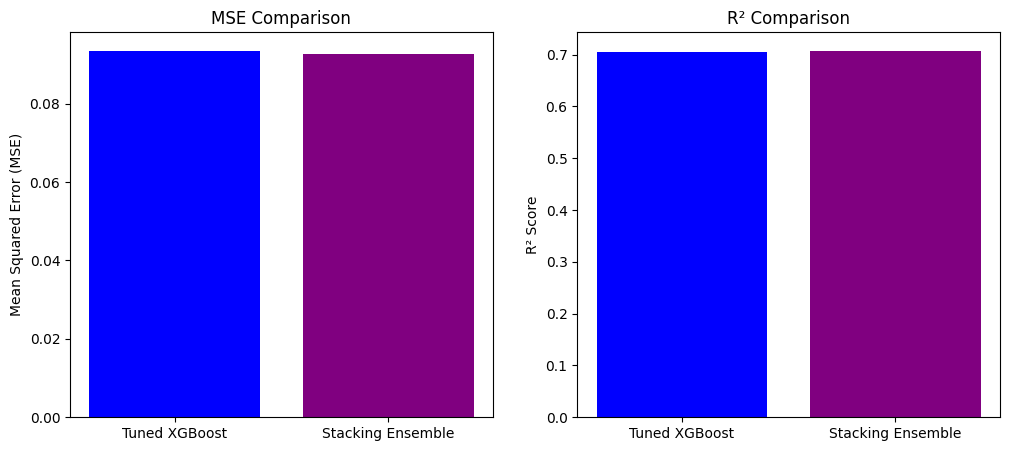

In [ ]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor  # LightGBM for efficiency
import seaborn as sns
import matplotlib.pyplot as plt

# Define base models (Keep them consistent with tuned settings)
base_models = [
    ('xgb', best_xgb),  # Best Tuned XGBoost
    ('rf', RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42))
]

# Stacking with LightGBM (faster than XGBoost)
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
)

# Train Stacking Model
stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)

# Evaluate
mse_stack = mean_squared_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

print(f"Stacking Ensemble - MSE: {mse_stack:.6f}, R2: {r2_stack:.6f}")

# ---- SEABORN PLOT COMPARISON ----
models = ['Tuned XGBoost', 'Stacking Ensemble']
mse_scores = [mse_xgb, mse_stack]
r2_scores = [r2_xgb, r2_stack]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# MSE Plot
sns.barplot(x=models, y=mse_scores, palette=['blue', 'orange'], ax=ax[0])
ax[0].set_ylabel("Mean Squared Error (MSE)")
ax[0].set_title("MSE Comparison")

# R2 Score Plot
sns.barplot(x=models, y=r2_scores, palette=['blue', 'orange'], ax=ax[1])
ax[1].set_ylabel("R² Score")
ax[1].set_title("R² Comparison")

# Add values on top of bars
for i, v in enumerate(mse_scores):
    ax[0].text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=10)
    
for i, v in enumerate(r2_scores):
    ax[1].text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=10)

plt.show()


Checking for clusters

In [ ]:
print([col for col in X.columns if 'clust_' in col])

['clust_kmeans_0', 'clust_kmeans_1', 'clust_kmeans_2', 'clust_kmeans_3', 'clust_gmm_0', 'clust_gmm_1', 'clust_gmm_2', 'clust_gmm_3', 'clust_spectral_0', 'clust_spectral_1', 'clust_spectral_2', 'clust_spectral_3']


Ensemble Stacking Model (XGBoost+RF+Gradient Boost +LightGBM)

In [ ]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# ---- DEFINE FEATURES & TARGET ----
X = df_encoded.drop(columns=['specz_redshift'])  
y = df_encoded['specz_redshift']

# ---- TRAIN-TEST SPLIT ----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---- DEFINE BASE MODELS (WITH OPTIMIZED PARAMS) ----
base_models = [
    ('xgb', XGBRegressor(n_estimators=500, learning_rate=0.03, max_depth=8, subsample=0.8, colsample_bytree=0.8, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=500, learning_rate=0.03, max_depth=5, random_state=42)),
    ('lgbm', LGBMRegressor(n_estimators=300, learning_rate=0.03, num_leaves=31, random_state=42))  
]

# ---- STACKING WITH LightGBM AS META-LEARNER ----
stacking_model = StackingRegressor(
    estimators=base_models, 
    final_estimator=LGBMRegressor(n_estimators=150, learning_rate=0.05, random_state=42)
)

# ---- TRAIN STACKING REGRESSOR ----
stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)

# ---- EVALUATE PERFORMANCE ----
mse_stack = mean_squared_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

print(f"🔥 Optimized Stacking Ensemble - MSE: {mse_stack:.6f}, R2: {r2_stack:.6f}")

# ---- EVALUATE INDIVIDUAL MODELS ----
individual_results = {}
for name, model in base_models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    individual_results[name] = (mse, r2)

# ---- VISUALIZATION (SEABORN) ----
models = ['XGBoost', 'RandomForest', 'GradientBoost', 'LightGBM', 'Stacking Ensemble']
mse_scores = [individual_results[m][0] for m in individual_results] + [mse_stack]
r2_scores = [individual_results[m][1] for m in individual_results] + [r2_stack]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# MSE Plot
sns.barplot(x=models, y=mse_scores, palette='viridis', ax=ax[0])
ax[0].set_ylabel("Mean Squared Error (MSE)")
ax[0].set_title("MSE Comparison")

# R2 Score Plot
sns.barplot(x=models, y=r2_scores, palette='viridis', ax=ax[1])
ax[1].set_ylabel("R² Score")
ax[1].set_title("R² Comparison")

# Add values on top of bars
for i, v in enumerate(mse_scores):
    ax[0].text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=10)
    
for i, v in enumerate(r2_scores):
    ax[1].text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=10)

plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3853
[LightGBM] [Info] Number of data points in the train set: 32076, number of used features: 29
[LightGBM] [Info] Start training from score 0.592784
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3852
[LightGBM] [Info] Number of data points in the train set: 25660, number of used features: 29
[LightGBM] [Info] Start training from score 0.590185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3853
[LightGBM] [Info] Number of data points in the train set: 25661, number of used features: 29
[LightGBM] [Info] Start tra

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


RandomizedSearchCV for best hyperparameters For Fine Tuned Ensemble Stcked model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

# ---- ONE-HOT ENCODING OF CLUSTER COLUMN ----
encoder = OneHotEncoder(sparse=False)
clusters_encoded = encoder.fit_transform(X_train[['cluster']])  # Convert clusters to categorical

# Replace 'cluster' column with encoded features
X_train = np.hstack((X_train.drop(columns=['cluster']), clusters_encoded))
X_test = np.hstack((X_test.drop(columns=['cluster']), encoder.transform(X_test[['cluster']])))  

# ---- DEFINE BASE MODELS ----
base_models = [
    ('xgb', XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=7, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=150, learning_rate=0.05, random_state=42)),
    ('lgbm', LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=42))  
]

# ---- STACKING REGRESSOR WITH LightGBM META-LEARNER ----
stacking_model = StackingRegressor(estimators=base_models, final_estimator=LGBMRegressor())

# ---- HYPERPARAMETER GRID ----
param_dist = {
    'xgb__n_estimators': np.arange(250, 400, 50),
    'xgb__learning_rate': [0.03, 0.05, 0.07], 
    'xgb__max_depth': [5, 7],  
    'rf__n_estimators': [150, 200, 250],  
    'gbr__n_estimators': [100, 150, 200],  
    'gbr__learning_rate': [0.03, 0.05],  
    'lgbm__n_estimators': [150, 200, 250],  
    'lgbm__learning_rate': [0.03, 0.05]
}

# ---- RANDOMIZED SEARCH ----
random_search = RandomizedSearchCV(
    stacking_model, param_dist, 
    n_iter=20, cv=2, scoring='r2', n_jobs=-1, verbose=2, random_state=42
)
random_search.fit(X_train, y_train)

# ---- PRINT BEST PARAMETERS ----
print("Best Parameters for Stacking:", random_search.best_params_)

# ---- TRAIN FINAL MODEL ----
best_model = random_search.best_estimator_
y_pred_stack = best_model.predict(X_test)

# ---- EVALUATE PERFORMANCE ----
mse_stack = mean_squared_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

print(f"🔥 Fine-Tuned Stacking Ensemble (Optimized) - MSE: {mse_stack:.6f}, R2: {r2_stack:.6f}")

# ---- TRAIN SEPARATE MODELS FOR EACH CLUSTER ----
cluster_models = {}
for cluster in np.unique(X_train[:, -encoder.categories_[0].shape[0]:]):  # Last cols are clusters
    X_train_cluster = X_train[X_train[:, -1] == cluster][:, :-encoder.categories_[0].shape[0]]  # Drop cluster cols
    y_train_cluster = y_train[X_train[:, -1] == cluster]

    model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=7, random_state=42)
    model.fit(X_train_cluster, y_train_cluster)
    
    cluster_models[cluster] = model

# ---- CLUSTER-SPECIFIC PREDICTION ----
y_pred_clustered = np.zeros(len(X_test))
for cluster in np.unique(X_test[:, -encoder.categories_[0].shape[0]:]):
    X_test_cluster = X_test[X_test[:, -1] == cluster][:, :-encoder.categories_[0].shape[0]]
    y_pred_clustered[X_test[:, -1] == cluster] = cluster_models[cluster].predict(X_test_cluster)

# ---- EVALUATE CLUSTERED MODEL ----
mse_clustered = mean_squared_error(y_test, y_pred_clustered)
r2_clustered = r2_score(y_test, y_pred_clustered)

print(f"🚀 Cluster-Specific Model - MSE: {mse_clustered:.6f}, R2: {r2_clustered:.6f}")


Fitting 2 folds for each of 20 candidates, totalling 40 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3852
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 29
[LightGBM] [Info] Start training from score 0.588068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3849
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 28
[LightGBM] [Info] Start training from score 0.597501
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, 

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.03, gbr__n_estimators=150, lgbm__learning_rate=0.03, lgbm__n_estimators=250, rf__n_estimators=150, xgb__learning_rate=0.03, xgb__max_depth=5, xgb__n_estimators=250; total time=10.6min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 4
[LightGBM] [Info] Start training from score 0.588068


/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.03, gbr__n_estimators=150, lgbm__learning_rate=0.03, lgbm__n_estimators=250, rf__n_estimators=150, xgb__learning_rate=0.03, xgb__max_depth=5, xgb__n_estimators=250; total time=10.6min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3850
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.598367
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3848
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.593794
[LightGBM] [Info] Auto-choosing col-wi

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=100, lgbm__learning_rate=0.03, lgbm__n_estimators=200, rf__n_estimators=200, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300; total time=12.2min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 4
[LightGBM] [Info] Start training from score 0.588068


/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=100, lgbm__learning_rate=0.03, lgbm__n_estimators=200, rf__n_estimators=200, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300; total time=12.3min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3852
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 29
[LightGBM] [Info] Start training from score 0.588068
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3849
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 28
[LightGBM] [Info] Start training from score 0.597501
[LightGBM] [Info] Auto-choosing col-wi

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.03, gbr__n_estimators=100, lgbm__learning_rate=0.05, lgbm__n_estimators=250, rf__n_estimators=250, xgb__learning_rate=0.03, xgb__max_depth=5, xgb__n_estimators=300; total time=15.0min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 4
[LightGBM] [Info] Start training from score 0.597501


/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.03, gbr__n_estimators=100, lgbm__learning_rate=0.05, lgbm__n_estimators=250, rf__n_estimators=250, xgb__learning_rate=0.03, xgb__max_depth=5, xgb__n_estimators=300; total time=15.1min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3850
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.598367
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3848
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.593794
[LightGBM] [Info] Auto-choosing row-wi

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=150, lgbm__learning_rate=0.05, lgbm__n_estimators=250, rf__n_estimators=250, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=350; total time=15.5min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3847
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.590235
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3850
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.598367
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020418 seconds

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=150, lgbm__learning_rate=0.05, lgbm__n_estimators=250, rf__n_estimators=250, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=350; total time=16.3min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 4
[LightGBM] [Info] Start training from score 0.588068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 4
[LightGBM] [Info] Start training from score 0.597501


/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=150, lgbm__learning_rate=0.03, lgbm__n_estimators=200, rf__n_estimators=250, xgb__learning_rate=0.07, xgb__max_depth=7, xgb__n_estimators=300; total time=16.4min


/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=150, lgbm__learning_rate=0.03, lgbm__n_estimators=200, rf__n_estimators=250, xgb__learning_rate=0.07, xgb__max_depth=7, xgb__n_estimators=300; total time=16.4min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3850
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.598367
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3847
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.586374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005550 seconds

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=200, lgbm__learning_rate=0.03, lgbm__n_estimators=200, rf__n_estimators=250, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=350; total time=17.0min


/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=200, lgbm__learning_rate=0.03, lgbm__n_estimators=200, rf__n_estimators=250, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=350; total time=17.0min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3852
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 29
[LightGBM] [Info] Start training from score 0.588068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3852
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 29
[LightGBM] [Info] Start training from score 0.588068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014337 seconds

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=150, lgbm__learning_rate=0.05, lgbm__n_estimators=150, rf__n_estimators=150, xgb__learning_rate=0.03, xgb__max_depth=7, xgb__n_estimators=350; total time=11.0min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3847
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.590235
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3847
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.588099
[LightGBM] [Info] Auto-choosing col-wi

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=150, lgbm__learning_rate=0.05, lgbm__n_estimators=150, rf__n_estimators=150, xgb__learning_rate=0.03, xgb__max_depth=7, xgb__n_estimators=350; total time=11.4min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3850
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.598367
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3848
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.593794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004926 seconds

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.03, gbr__n_estimators=150, lgbm__learning_rate=0.05, lgbm__n_estimators=250, rf__n_estimators=150, xgb__learning_rate=0.03, xgb__max_depth=7, xgb__n_estimators=300; total time=11.2min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 4
[LightGBM] [Info] Start training from score 0.588068


/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.03, gbr__n_estimators=150, lgbm__learning_rate=0.05, lgbm__n_estimators=250, rf__n_estimators=150, xgb__learning_rate=0.03, xgb__max_depth=7, xgb__n_estimators=300; total time=11.4min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3852
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 29
[LightGBM] [Info] Start training from score 0.588068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3849
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 28
[LightGBM] [Info] Start training from score 0.597501
[LightGBM] [Info] Auto-choosing row-wi

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.03, gbr__n_estimators=100, lgbm__learning_rate=0.05, lgbm__n_estimators=250, rf__n_estimators=200, xgb__learning_rate=0.07, xgb__max_depth=7, xgb__n_estimators=350; total time=12.9min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3848
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.593794
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3849
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.601214
[LightGBM] [Info] Auto-choosing row-wi

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.03, gbr__n_estimators=100, lgbm__learning_rate=0.05, lgbm__n_estimators=250, rf__n_estimators=200, xgb__learning_rate=0.07, xgb__max_depth=7, xgb__n_estimators=350; total time=12.6min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3847
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.586374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3847
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.590235
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008806 seconds

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=200, lgbm__learning_rate=0.05, lgbm__n_estimators=150, rf__n_estimators=200, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=350; total time=14.8min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 4
[LightGBM] [Info] Start training from score 0.597501


/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=200, lgbm__learning_rate=0.05, lgbm__n_estimators=150, rf__n_estimators=200, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=350; total time=14.8min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3852
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 29
[LightGBM] [Info] Start training from score 0.588068
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3849
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 28
[LightGBM] [Info] Start training from score 0.597501
[LightGBM] [Info] Auto-choosing row-wi

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.03, gbr__n_estimators=150, lgbm__learning_rate=0.03, lgbm__n_estimators=150, rf__n_estimators=250, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300; total time=15.7min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 4
[LightGBM] [Info] Start training from score 0.597501
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3852
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 29
[LightGBM] [Info] Start training from score 0.588068
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005822 seconds.

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.03, gbr__n_estimators=150, lgbm__learning_rate=0.03, lgbm__n_estimators=150, rf__n_estimators=250, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300; total time=15.8min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3849
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.601214
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3849
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 28
[LightGBM] [Info] Start training from score 0.597501
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016595 seconds

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=150, lgbm__learning_rate=0.05, lgbm__n_estimators=250, rf__n_estimators=250, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=250; total time=15.7min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3848
[LightGBM] [Info] Number of data points in the train set: 12831, number of used features: 28
[LightGBM] [Info] Start training from score 0.588979
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 4
[LightGBM] [Info] Start training from score 0.588068


/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=150, lgbm__learning_rate=0.05, lgbm__n_estimators=250, rf__n_estimators=250, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=250; total time=15.9min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3852
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 29
[LightGBM] [Info] Start training from score 0.588068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3849
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 28
[LightGBM] [Info] Start training from score 0.597501
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016326 seconds

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=150, lgbm__learning_rate=0.05, lgbm__n_estimators=150, rf__n_estimators=250, xgb__learning_rate=0.07, xgb__max_depth=7, xgb__n_estimators=350; total time=16.2min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3849
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.601214
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3849
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.601214
[LightGBM] [Info] Auto-choosing col-wi

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=200, lgbm__learning_rate=0.03, lgbm__n_estimators=250, rf__n_estimators=200, xgb__learning_rate=0.07, xgb__max_depth=7, xgb__n_estimators=350; total time=14.5min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3849
[LightGBM] [Info] Number of data points in the train set: 12831, number of used features: 28
[LightGBM] [Info] Start training from score 0.595743
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3849
[LightGBM] [Info] Number of data points in the train set: 12831, number of used features: 28
[LightGBM] [Info] Start training from score 0.595743
[LightGBM] [Info] Auto-choosing col-wi

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=150, lgbm__learning_rate=0.05, lgbm__n_estimators=150, rf__n_estimators=250, xgb__learning_rate=0.07, xgb__max_depth=7, xgb__n_estimators=350; total time=16.3min


/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=200, lgbm__learning_rate=0.03, lgbm__n_estimators=250, rf__n_estimators=200, xgb__learning_rate=0.07, xgb__max_depth=7, xgb__n_estimators=350; total time=14.6min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3852
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 29
[LightGBM] [Info] Start training from score 0.588068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3849
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 28
[LightGBM] [Info] Start training from score 0.597501
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007628 seconds

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=100, lgbm__learning_rate=0.03, lgbm__n_estimators=250, rf__n_estimators=200, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=350; total time=12.4min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3850
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.598367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3848
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start tra

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=100, lgbm__learning_rate=0.03, lgbm__n_estimators=250, rf__n_estimators=200, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=350; total time=12.8min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3848
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.593794


/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=200, lgbm__learning_rate=0.03, lgbm__n_estimators=250, rf__n_estimators=150, xgb__learning_rate=0.03, xgb__max_depth=7, xgb__n_estimators=250; total time=11.9min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3849
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.601214
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3849
[LightGBM] [Info] Number of data points in the train set: 12831, number of used features: 28
[LightGBM] [Info] Start tra

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=200, lgbm__learning_rate=0.03, lgbm__n_estimators=250, rf__n_estimators=150, xgb__learning_rate=0.03, xgb__max_depth=7, xgb__n_estimators=250; total time=11.9min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3848
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.593794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3849
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.601214
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.03, gbr__n_estimators=100, lgbm__learning_rate=0.03, lgbm__n_estimators=200, rf__n_estimators=150, xgb__learning_rate=0.07, xgb__max_depth=7, xgb__n_estimators=250; total time= 9.7min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3847
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.586374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3847
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.590235
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001223 seconds

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.03, gbr__n_estimators=100, lgbm__learning_rate=0.03, lgbm__n_estimators=200, rf__n_estimators=150, xgb__learning_rate=0.07, xgb__max_depth=7, xgb__n_estimators=250; total time= 9.9min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3847
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.586374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3847
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.590235
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001381 seconds

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=150, lgbm__learning_rate=0.05, lgbm__n_estimators=250, rf__n_estimators=250, xgb__learning_rate=0.03, xgb__max_depth=5, xgb__n_estimators=350; total time=13.3min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3850
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.598367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3847
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.586374
[LightGBM] [Info] Auto-choosing col-wi

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.03, gbr__n_estimators=150, lgbm__learning_rate=0.03, lgbm__n_estimators=250, rf__n_estimators=150, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=250; total time= 8.5min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 4
[LightGBM] [Info] Start training from score 0.597501
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3849
[LightGBM] [Info] Number of data points in the train set: 12831, number of used features: 28
[LightGBM] [Info] Start training from score 0.598386
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001176 seconds.

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.05, gbr__n_estimators=150, lgbm__learning_rate=0.05, lgbm__n_estimators=250, rf__n_estimators=250, xgb__learning_rate=0.03, xgb__max_depth=5, xgb__n_estimators=350; total time=13.5min


/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.03, gbr__n_estimators=150, lgbm__learning_rate=0.03, lgbm__n_estimators=250, rf__n_estimators=150, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=250; total time= 8.4min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3850
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.598367
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3848
[LightGBM] [Info] Number of data points in the train set: 12830, number of used features: 28
[LightGBM] [Info] Start training from score 0.593794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001032 seconds

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 16038, number of used features: 4
[LightGBM] [Info] Start training from score 0.588068


/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END gbr__learning_rate=0.03, gbr__n_estimators=100, lgbm__learning_rate=0.03, lgbm__n_estimators=250, rf__n_estimators=200, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=250; total time= 9.1min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3853
[LightGBM] [Info] Number of data points in the train set: 32076, number of used features: 29
[LightGBM] [Info] Start training from score 0.592784
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3852
[LightGBM] [Info] Number of data points in the train set: 25660, number of used features: 29
[LightGBM] [Info] Start training from score 0.590185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001771 seconds

/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Save Variables

In [17]:
import dill

# Save the entire session to a file
dill.dump_session("full_session.pkl")


Load Variables

In [ ]:
# import dill

# # Load the entire session from the file
# dill.load_session("full_session.pkl")


2025-02-27 17:48:52.648373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740658732.701643   14624 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740658732.717109   14624 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 17:48:52.832651: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
